In [3]:
%load_ext autoreload
%autoreload 2

In [19]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict, write_json
from synbio_morpher.utils.results.analytics.timeseries import compute_step_response_times

# fn = 'data/simulate_circuits/2025_02_11__13_56_51/tabulated_mutation_info.json'
# dir_s = 'data/simulate_circuits/2025_02_01__00_22_38'
dir_s = 'data/simulate_circuits/2025_02_11__13_56_51'
# fn = 'data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json'

# d = pd.read_json(fn)

ts = np.load(os.path.join(dir_s, 'ts.npy'))
ys = np.load(os.path.join(dir_s, 'ys.npy'))
config = load_json_as_dict(os.path.join(dir_s, 'config.json'))
analytics = load_json_as_dict(os.path.join(dir_s, 'analytics.json'))
analytics['steady_states'] = np.array(analytics['steady_states'])


In [20]:
data = load_json_as_dict(os.path.join(dir_s, 'tabulated_mutation_info.json'))


In [21]:
import jax
from functools import partial
t_end = len(ts)
idx_c = 12
f_resp = jax.vmap(partial(compute_step_response_times, signal_time=ts[0], t=ts[:t_end]))
r = f_resp(data=np.swapaxes(ys[:, :t_end], -1, -2), steady_states=analytics['steady_states'][..., None])



<Axes: xlabel='response_time', ylabel='Count'>

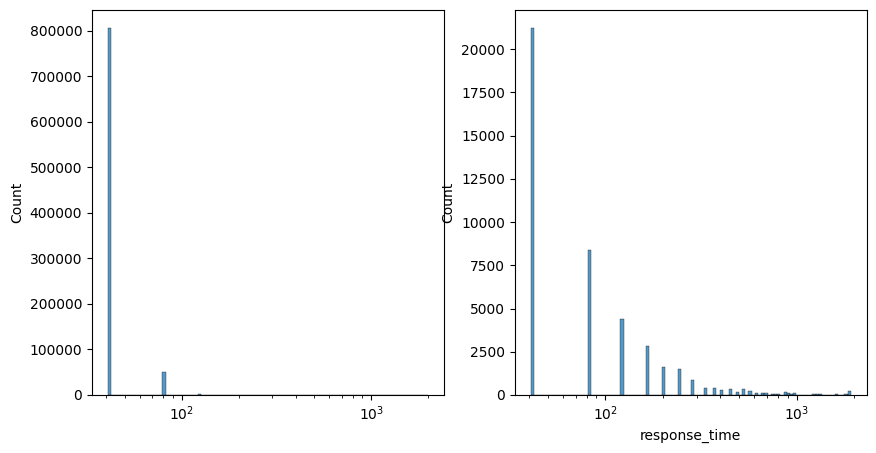

In [22]:
# nshow = int(2e4)
# plt.plot((ts * np.ones_like(ys[:nshow, :, -2])).T, ys[:nshow, :, -2].T, alpha=0.05, color='b')
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
sns.histplot(r[:, -1], log_scale=True, bins=100)
ax = plt.subplot(1, 2, 2)
sns.histplot(data, x='response_time', log_scale=True, bins=100)

In [1]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict, write_json
import pandas as pd
# fn = 'data/simulate_circuits/2025_01_28__21_36_14/analytics.json'
# fn = 'data/simulate_circuits/2025_01_29__14_52_44/analytics.json'
# fn = 'data/simulate_circuits/2025_01_29__18_12_38/analytics.json'
# fn = 'data/simulate_circuits/2025_02_01__00_22_38/analytics.json'
fn = 'data/simulate_circuits/2025_01_29__18_12_38/tabulated_mutation_info.json'
# fn = 'data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json'
# fn = 'data/simulate_circuits/2025_02_11__13_56_51/analytics.json'
# fn = 'data/simulate_circuits/2025_02_11__13_56_51/tabulated_mutation_info.json'

rn = {'sensitivity_wrt_species-6': 'sensitivity',
      'precision_wrt_species-6': 'precision',
      'response_time_wrt_species-6': 'response_time'}

if 'analytics' in fn:
    d = load_json_as_dict(fn)
    for k, v in rn.items():
        if k in d:
            d[v] = d.pop(k)
else:
    d = pd.read_json(fn)
    for k, v in rn.items():
        d.rename(columns={k: v}, inplace=True)
# write_json(d, fn)
# d.keys()
d.columns


Index(['RMSE', 'fold_change', 'initial_steady_states', 'max_amount',
       'min_amount', 'overshoot', 'precision', 'response_time', 'sensitivity',
       'steady_states', 'Log sensitivity', 'Log precision', 'sample_name',
       'circuit_name', 'mutation_name', 'mutation_num', 'mutation_type',
       'mutation_positions', 'path_to_template_circuit', 'num_interacting',
       'num_self_interacting', 'energies_0-0', 'energies_0-1', 'energies_0-2',
       'energies_1-1', 'energies_1-2', 'energies_2-2'],
      dtype='object')

In [2]:
write_json(d, fn)


In [ ]:
import numpy as np
from scipy.stats import entropy
from sklearn.preprocessing import KBinsDiscretizer
import pandas as pd

def calculate_cross_category_mi(data, categories, n_bins=10):
    """
    Calculate mutual information between different categories of gene circuit components.
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame where rows are different circuits and columns are component properties
    categories : dict
        Dictionary mapping category names to lists of column names
    n_bins : int
        Number of bins for discretizing continuous variables
    
    Returns:
    --------
    dict
        Dictionary containing MI matrices for each category pair
    """
    
    def _discretize_data(df, cols, n_bins):
        """Helper function to discretize continuous data"""
        discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
        df_disc = df.copy()
        for col in cols:
            if df[col].dtype in [np.float64, np.int64]:
                df_disc[col] = discretizer.fit_transform(df[col].values.reshape(-1, 1))
        return df_disc
    
    def _calculate_mi(x, y):
        """Calculate mutual information between two discrete variables"""
        # Calculate joint probability distribution
        joint_dist = np.histogram2d(x, y, bins=[np.unique(x).size, np.unique(y).size])[0]
        joint_dist = joint_dist / joint_dist.sum()
        
        # Calculate marginal distributions
        px = joint_dist.sum(axis=1)
        py = joint_dist.sum(axis=0)
        
        # Calculate entropies
        hx = entropy(px)
        hy = entropy(py)
        hxy = entropy(joint_dist.flatten())
        
        # Calculate mutual information
        mi = hx + hy - hxy
        return mi

    # Discretize all continuous variables
    data_disc = _discretize_data(data, data.columns, n_bins)
    
    # Calculate MI between all category pairs
    mi_results = {}
    for cat1 in categories:
        for cat2 in categories:
            if cat1 < cat2:  # Only calculate upper triangle
                mi_matrix = np.zeros((len(categories[cat1]), len(categories[cat2])))
                for i, col1 in enumerate(categories[cat1]):
                    for j, col2 in enumerate(categories[cat2]):
                        mi_matrix[i, j] = _calculate_mi(
                            data_disc[col1].values,
                            data_disc[col2].values
                        )
                mi_results[f"{cat1}_vs_{cat2}"] = {
                    'matrix': mi_matrix,
                    'rows': categories[cat1],
                    'cols': categories[cat2]
                }
    
    return mi_results

def plot_mi_heatmap(mi_results, category_pair):
    """
    Plot heatmap of mutual information between two categories.
    
    Parameters:
    -----------
    mi_results : dict
        Output from calculate_cross_category_mi
    category_pair : str
        Key from mi_results to plot (e.g., "promoters_vs_terminators")
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    result = mi_results[category_pair]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        result['matrix'],
        xticklabels=result['cols'],
        yticklabels=result['rows'],
        cmap='viridis',
        annot=True,
        fmt='.2f'
    )
    plt.title(f'Mutual Information: {category_pair}')
    plt.tight_layout()
    return plt

# Example usage:
if __name__ == "__main__":
    # Example data structure
    data = pd.DataFrame({
        'promoter_strength': np.random.random(100),
        'promoter_leakiness': np.random.random(100),
        'rbs_strength': np.random.random(100),
        'rbs_efficiency': np.random.random(100),
        'terminator_efficiency': np.random.random(100),
        'protein_stability': np.random.random(100)
    })
    
    # Define categories
    categories = {
        'promoters': ['promoter_strength', 'promoter_leakiness'],
        'rbs': ['rbs_strength', 'rbs_efficiency'],
        'output': ['terminator_efficiency', 'protein_stability']
    }
    
    # Calculate MI
    mi_results = calculate_cross_category_mi(data, categories)
    
    # Plot results
    plot_mi_heatmap(mi_results, 'promoters_vs_rbs')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Create figure
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Left Panel: Microscopic System
axs[0].plot(np.sin(np.linspace(0, 10, 100)), label='Component 1', color='black')
axs[0].plot(np.cos(np.linspace(0, 10, 100)), label='Component 2', color='black')
axs[0].arrow(50, 0.5, 10, 0, head_width=0.1, head_length=5, fc='blue', ec='blue')
axs[0].arrow(70, -0.5, -10, 0, head_width=0.1, head_length=5, fc='green', ec='green')
axs[0].set_title("Microscopic View")
axs[0].axis('off')

# Middle Panel: Network Representation
G = nx.DiGraph()
G.add_edges_from([(0, 1), (1, 2), (2, 0), (2, 3)])
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=['pink', 'blue', 'green', 'purple'], ax=axs[1], edge_color='black')
axs[1].set_title("Abstracted Network")

# Right Panel: Dynamics Plot
t = np.linspace(0, 10, 100)
axs[2].plot(t, np.tanh(t - 5), label='Variable 1', color='purple')
axs[2].plot(t, -np.tanh(t - 5), label='Variable 2', color='blue')
axs[2].plot(t, 0.1 * np.sin(t), label='Variable 3', color='green')
axs[2].axvline(5, linestyle='dashed', color='gray')
axs[2].legend()
axs[2].set_title("Macroscopic Dynamics")

plt.tight_layout()
plt.show()


# New Figure: Curved Arrows for Three Nodes
fig, ax = plt.subplots(figsize=(4, 4))
G = nx.DiGraph()
edges = [("RNA 1", "RNA 2"), ("RNA 2", "RNA 3"), ("RNA 3", "RNA 1"), ("RNA 2", "RNA 1"), ("RNA 3", "RNA 2"), ("RNA 1", "RNA 3")]
G.add_edges_from(edges)
for node in G.nodes():
    G.add_edge(node, node)
pos = {"RNA 1": (0, 1), "RNA 2": (-1, 0), "RNA 3": (1, 0)}

# Assign the same opacity for each pair of edges between the same nodes
edge_opacity = {}
opacities = [0.2, 0.6, 1.0]
opacities_iter = iter(opacities)
for u, v in edges:
    if (v, u) in edge_opacity:
        edge_opacity[(u, v)] = edge_opacity[(v, u)]
    else:
        edge_opacity[(u, v)] = next(opacities_iter)

edge_colors = [(0, 0, 0, edge_opacity[edge]) for edge in edges]
nx.draw(G, pos, with_labels=True, labels={node: node for node in G.nodes()}, node_color='lightgreen', edge_color=edge_colors, arrows=True, connectionstyle='arc3,rad=0.2', ax=ax, node_size=2000, node_shape='o')
ax.set_title("Curved Arrows Between Nodes with Paired Opacity")
plt.tight_layout()
plt.show()
